In [8]:
# install necessary libraries

!pip install transformers 
!pip install torch==6.0
!pip install datasets

from IPython.display import clear_output
clear_output()

In [9]:
import datasets
from datasets import load_dataset
import pandas as pd

dataset = load_dataset('emotone_ar')  
df = dataset['train'].to_pandas()
df

Generating train split:   0%|          | 0/10065 [00:00<?, ? examples/s]

Dataset emotone_ar downloaded and prepared to /root/.cache/huggingface/datasets/emotone_ar/default/0.0.0/36bfa7e8bdf640ccb3d5701933cfde2fa7051f22881cfab2962122771d32c430. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,tweet,label
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,0
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,1
2,كتنا نيله ف حظنا الهباب xD,3
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,2
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,0
...,...,...
10060,2222: يلا يا جماعه حفله عمرو دياب خلصت نريح شو...,3
10061,Mohamed5: اييييه دااا 😲😲 اوزيييل❤,6
10062,عملتلها ريتويت بمناسبه ساره بتاعه الاوليمبياد 😃,0
10063,وعليك قبلنا يانجم النجوم ياعندليب الحب والاحساس,2


In [10]:
df.label.value_counts()

0    1550
1    1444
2    1281
3    1256
4    1220
7    1207
5    1062
6    1045
Name: label, dtype: int64

In [19]:
mapping_labels = {0:'none',
1:'anger' ,
2:'joy', 
3:'sadness',
4:'love' ,
5:'sympathy',
6:'surprise',
7:'fear'}

# Data Preprocessing (2)

In [30]:
# https://github.com/motazsaad/process-arabic-text/blob/master/clean_arabic_text.py

import re
import string
import sys
import argparse

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)

def remove_diacritics(text):
  text = re.sub(arabic_diacritics, '', text)
  return text

def remove_repeating_char(text):
  return re.sub(r'(.)\1+', r'\1', text)

def remove_newlines(text):
  text = re.sub('\n'," . ",text)
  return text  

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def replace_emojis(text): 
    text = re.sub(r'<3|< 3|❤️|💖|😍|💕|😘|🥰|💕|💝|💗|💜|💙|🖤|💚|💛|🤍|❤',
                  ' قلب ',
                  text) 

    text = re.sub(r':P|:-P|😂|🤣',
                  ' ضحك ',
                  text)

    text = re.sub(r'[☺😌😁😃😄😆😊😸😺😊😀😋☺️🙂💃]',
                  ' سعادة ',
                  text)
    
    
    text = re.sub(r':D',
                  ' سعادة ',
                  text)

    text = re.sub(r'[😥😣😓😔😕☹️🙁😖😞😟😢😭😩😿😫😩💔]',
                  ' حزن  ',
                  text)
    text = re.sub(r'(::|\)-:)',
                  '  حزن  ', 
                  text)
    text = re.sub(r'(:,\(|:\'\(|:"\()',
                  ' حزن ', 
                  text)

    text = re.sub(r'[😨😱😵]',
                  ' مفاجأة ', 
                  text)

    text = re.sub(r'[😳😅🙈]',
                  ' محرج ', 
                  text)

    text = re.sub(r'[😤😠😡🤬👿]',
                  ' غضب ', 
                  text)

    text = re.sub(r'[😑😒🙄😐😶]',
                  ' ملل ', 
                  text)

    text = re.sub('[\U0001F600-\U0001FFFF]'," ", text)
    text = re.sub('[\U0001F300-\U0001F5FF]'," ", text)
    text = re.sub('[\U0001F680-\U0001F6FF]'," ", text)
    text = re.sub('["\U0001F1E0-\U0001F1FF]'," ", text)

    
    weirdPatterns = re.compile("["
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    text = weirdPatterns.sub(r'', text)
    
    return text


In [31]:
def text_preprocessing(text):
    text = replace_emojis(remove_repeating_char(remove_newlines(text)))
    return text

In [32]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

%matplotlib inline

In [33]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [34]:
def text_preprocessing_2(text):
    text = replace_emoji(remove_repeating_char(remove_newlines(text)))
    return text

In [35]:
# import a model from huggingface
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer


model_path = 'UBC-NLP/MARBERTv2'
# 'UBC-NLP/MARBERT'
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [36]:
all_tweets = df.tweet.values

encoded_tweets = [tokenizer.encode(text_preprocessing_2(sent), add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  43


In [37]:
# Specify max length to trancuate/pad to
MAX_LEN = 50
# 50 for marbert ??
# 65 arabert ??

def preprocessing_for_bert(data, text_preprocessing_fn = text_preprocessing ):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for i,tweet in enumerate(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_fn(r""+tweet),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',        # Pad sentence to max length
            return_attention_mask=True,     # Return attention mask
            truncation = True 
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [38]:
from sklearn.model_selection import train_test_split

# Train: 80% Test: 20%
df_train, df_test = train_test_split(
  df,
  test_size=0.2,
  random_state= 2023
)

# Test: 50% Validation: 50%
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state= 2023
)

X_train = df_train['tweet'].to_numpy()
X_val = df_val['tweet'].to_numpy()

y_train = df_train['label'].to_numpy()
y_val = df_val['label'].to_numpy()     

In [39]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


In [40]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)


# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [41]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 8 # 8 classes

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(model_path)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 2.32 s, sys: 530 ms, total: 2.85 s
Wall time: 5.57 s


In [88]:
# To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

# Batch size: 16 or 32
# Learning rate (Adam): 5e-5, 3e-5 or 2e-5
# Number of epochs: 2, 3, 4

from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=2):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [89]:
import random
import time
 
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [90]:
set_seed(42)    # Set seed for reproducibility

In [91]:
epoch_num = 2
bert_classifier, optimizer, scheduler = initialize_model(epochs=epoch_num)
trainer = train(bert_classifier, train_dataloader, val_dataloader, epochs=epoch_num, evaluation=True)

Some weights of the model checkpoint at UBC-NLP/MARBERTv2 were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is de

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.978623   |     -      |     -     |   3.52   
   1    |   40    |   1.729341   |     -      |     -     |   3.35   
   1    |   60    |   1.443560   |     -      |     -     |   3.34   
   1    |   80    |   1.327224   |     -      |     -     |   3.36   
   1    |   100   |   1.130142   |     -      |     -     |   3.34   
   1    |   120   |   1.137885   |     -      |     -     |   3.35   
   1    |   140   |   1.077506   |     -      |     -     |   3.35   
   1    |   160   |   0.946936   |     -      |     -     |   3.34   
   1    |   180   |   0.936567   |     -      |     -     |   3.34   
   1    |   200   |   0.928970   |     -      |     -     |   3.35   
   1    |   220   |   0.966988   |     -      |     -     |   3.34   
   1    |   240   |   0.872434   |     -      |     -     |   3.36   


In [92]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [93]:
y_test = df_test['label'].to_numpy()
test_labels = torch.tensor(y_test)
test_inputs, test_masks = preprocessing_for_bert(df_test.tweet)


# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks,test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [94]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)
tensor = torch.from_numpy(probs)
ytest = torch.max(tensor, dim=1)

In [95]:
from sklearn.metrics import confusion_matrix, classification_report
class_names = ['none',
'anger' ,
'joy', 
'sadness',
'love' ,
'sympathy',
'surprise',
'fear']
print(classification_report(df_test.label, ytest.indices, target_names=class_names))


              precision    recall  f1-score   support

        none       0.78      0.83      0.80       159
       anger       0.81      0.84      0.83       148
         joy       0.65      0.67      0.66       122
     sadness       0.75      0.68      0.71       105
        love       0.84      0.76      0.80       122
    sympathy       0.88      0.96      0.92       111
    surprise       0.78      0.73      0.76       116
        fear       0.95      0.94      0.94       124

    accuracy                           0.81      1007
   macro avg       0.81      0.80      0.80      1007
weighted avg       0.81      0.81      0.80      1007



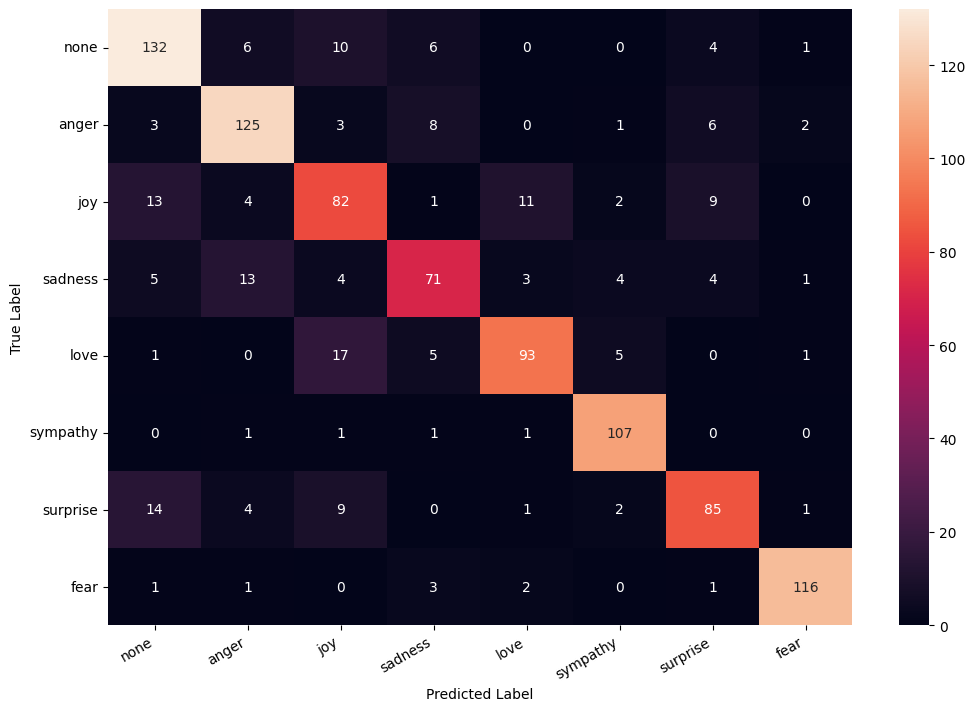

In [96]:
#Plot confusion matrix
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 8

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label');
cm = confusion_matrix(df_test.label,  ytest.indices)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Inference




MARBERT achieved the highest Accuacy between all the other BERT-based models. We evaluate it further by testing it on some tweets.

In [ ]:
def test_model(my_input):
    import pandas as pd
    import seaborn as sns
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 12, 8

    encoded_text = tokenizer.encode_plus(
      text_preprocessing(my_input),
      return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)
    output = bert_classifier(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    print(f'tweet text: {my_input}')
    print(f'Emotion  : {class_names[prediction]}')
    print(" ")

#     pred_df = pd.DataFrame({
#       'class_names': class_names,
#       'values': output.detach().cpu().numpy()[0]
#     })

#     sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
#     plt.ylabel('Emotion')
#     plt.xlabel('probability')
#     plt.xlim([0, 3]);

In [112]:
test_model("أنا عايز أنام")

test_model("أنا مبسوط")

test_model("احنا هانتخرج")

test_model("مش عارف احل الاساينمنت")

test_model("ادا احنا هنتخرج!")

test_model("احنا هنتخرج!")

test_model("الأكل حلو أوي")

test_model("الأكل مش حلو أوي")

test_model("الامتحان بكرا و انا مش عارف حاجة")

test_model("الامتحان بكرا ")

test_model("😡😡")

test_model("😠😡🤬")

test_model("تراني تاثرت")

test_model("يعيني سهران طول اليل")

test_model("❤️❤️❤️")

test_model("مش معقول اللي بيحصل ده")

test_model("وحشتيني جدا")
############
test_model("ماروحتش مدن كتير في حياتي بس القاهرة ليها كتمة معيّنة كده مالهاش وصف أدق من وصف الشيخ حسني في الكيت كات زي ما يكون غضب ربنا حلّ ع الدنيا")

test_model(" بمووت فيها بجد")

test_model("فاكر لما كان عندك إهتمامات وشخصية قبل ما الرأسمالية تعرفك؟")



tweet text: أنا عايز أنام
Emotion  : sadness
 
tweet text: أنا مبسوط
Emotion  : joy
 
tweet text: احنا هانتخرج
Emotion  : sadness
 
tweet text: مش عارف احل الاساينمنت
Emotion  : sadness
 
tweet text: ادا احنا هنتخرج!
Emotion  : surprise
 
tweet text: احنا هنتخرج!
Emotion  : surprise
 
tweet text: الأكل حلو أوي
Emotion  : joy
 
tweet text: الأكل مش حلو أوي
Emotion  : sadness
 
tweet text: الامتحان بكرا و انا مش عارف حاجة
Emotion  : fear
 
tweet text: الامتحان بكرا 
Emotion  : fear
 
tweet text: 😡😡
Emotion  : sadness
 
tweet text: 😠😡🤬
Emotion  : sadness
 
tweet text: تراني تاثرت
Emotion  : sympathy
 
tweet text: يعيني سهران طول اليل
Emotion  : sadness
 
tweet text: ❤️❤️❤️
Emotion  : love
 
tweet text: مش معقول اللي بيحصل ده
Emotion  : surprise
 
tweet text: وحشتيني جدا
Emotion  : joy
 
tweet text: ماروحتش مدن كتير في حياتي بس القاهرة ليها كتمة معيّنة كده مالهاش وصف أدق من وصف الشيخ حسني في الكيت كات زي ما يكون غضب ربنا حلّ ع الدنيا
Emotion  : sadness
 
tweet text:  بمووت فيها بجد
Emotion